# Manipulate waveform decomposition frame and find corotating angles

### Setup Environment

In [119]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
# Import needed packages from positive
from positive.plotting import sYlm_mollweide_plot
from positive import alert
# Import other usefuls
from os.path import expanduser
from nrutils import scsearch,gwylm
from nrutils.core.basics import *
from numpy import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Find a simulation

In [137]:
A = scsearch(institute='bam',keyword='q1.2_dqdcp2',verbose=True)
# A = scsearch(institute='gt',keyword='Sq4_d9_a0.6_oth.090_rr_M140',verbose=True)
# A = scsearch(q=1,keyword='hrq',verbose=True)
# A = scsearch(precessing=True,verbose=True)
# A = scsearch(keyword='EP_um2D10_d6_sz-n88')

(scsearch)>> Found institute (='bam') keyword.
(scsearch)>> Found keyword (='q1.2_dqdcp2') keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 2 possibly degenerate simulations:
[0001][silures] BAM: 1chi0.67-2chi0.42-p-q1.50	(q1.2_dqdcp2)
[0002][hogshead] dirac-nr-followup: 1chi0.67-2chi0.42-p-q1.50	(q1.2_dqdcp2)



### Load waveform data

In [163]:
# y = gwylm( A[0], lmax=3, clean=True )
# y = gwylm( A[0], lm=[(2,2),(2,1),(2,0)], clean=False )

simdir = '/Users/book/MOUNT/tmp/mnt/hogshead/NR_data/ReducedData-hogshead/q2/q2a04t90dPm1_T_96_408/'
y = gwylm( simdir, lmax=3, clean=True )

(gwylm!)>> You have input a directory rather than an scentry object. We will try to convert the directory to an scentry object, but this is slower than using the our catalog system. Please consider modifying the appropriate configuretion file (i.e. in "/Users/book/JOKI/Libs/KOALA/nrutils_dev/nrutils/config/") to accommodate your new simulation, or perhaps create a new configuration file. Given your new or updated configuration file, please run nrutils.scbuild("my_config_name") to update your local catalog. If you are confident that all has gone well, you may also wish to push changes in your catalog (to the master repo). Live long and prosper. -- Lionel
(bam.py)>> Initial parameters corresponding to the bbh file's aftrejunktime will be used to populate metadata.
(bam.py!)>> Warning: The estimated after junk binary separation is significantly different than the value stored in the bbh file: x from calculation = 11.428016, x from bbh file=11.629900. The user should understand whether thi

### Try to calculate corotating angles

In [192]:

# Options
kind = 'psi4'
domain = 'time'

# Construct dictionary of multipoles using all multipoles available
mp = { (l,m) : ( y.lm[l,m][kind].y if domain in ('t','time') else y.lm[l,m][kind].fd_y ) for l,m in y.lm  }
domain_vals = y.lm[2,2][kind].t if domain in ('t','time') else y.lm[2,2][kind].f

# Calculate corotating angles using low-level function
alpha,beta,gamma = calc_coprecessing_angles( mp, domain_vals )
x,yy,z            = calc_coprecessing_angles( mp, domain_vals, return_xyz=True )


### Plot the angles and the waveform amplitude for reference

(605.25, 2062.5)

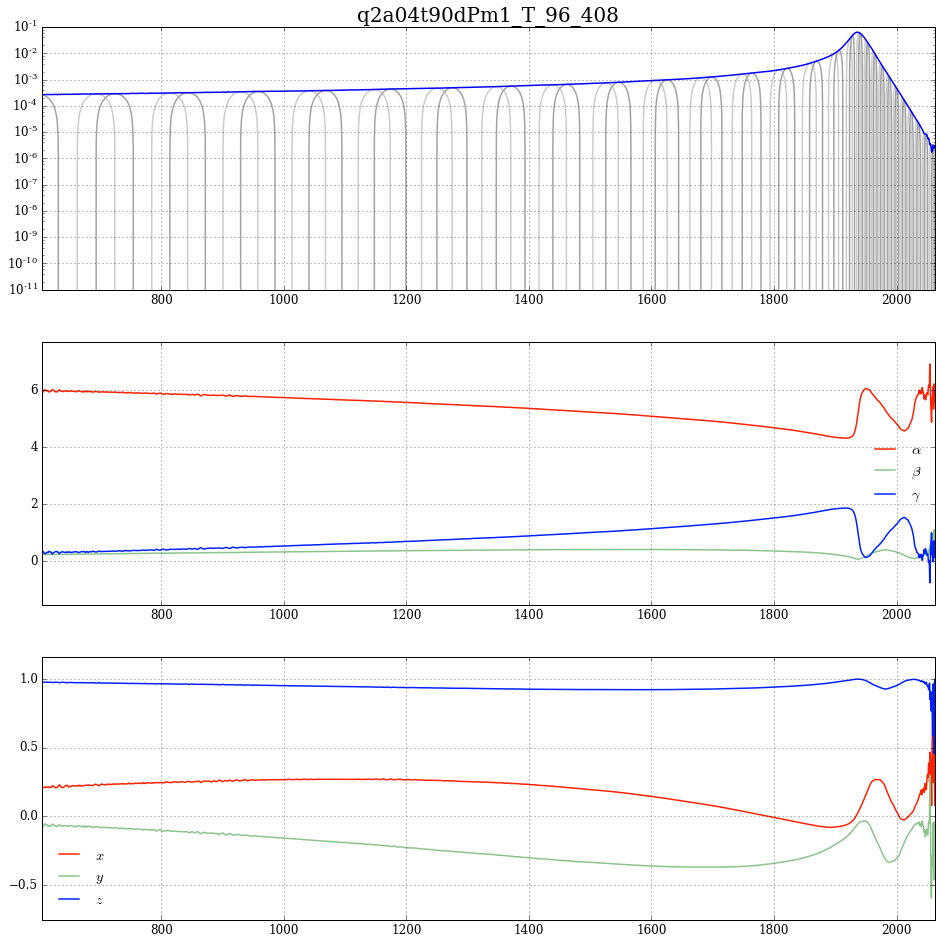

In [193]:

#
fig = figure( figsize=4*figaspect(1) )
clr = rgb(3,jet=True); grey = ones(3)*0.8
lw = 1.5

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#
mask = (domain_vals>=domain_min) & (domain_vals<=domain_max)

#
ax = subplot(3,1,1)
title( y.simname )
if domain in ('t','time'):
    plot( domain_vals, y.lm[2,2][kind].plus, color=grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].cross, color=0.8*grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].amp, linewidth = lw )
    yscale('log')
else:
    plot( domain_vals, y.lm[2,2][kind].fd_amp, linewidth = lw )
    xscale('log'); yscale('log')
    ylim( lim(y.lm[2,2][kind].fd_amp[mask]) )
grid()

#
subplot(3,1,2,sharex=ax)
reshift = lambda V: V - V[mask][0] + mod(V[mask][0],2*pi)
plot( domain_vals, reshift(alpha), color = clr[0], linewidth = lw, label=r'$\alpha$' )
plot( domain_vals, reshift(beta),  color = clr[1], linewidth = lw, label=r'$\beta$' )
plot( domain_vals, reshift(gamma), color = clr[2], linewidth = lw, label=r'$\gamma$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([reshift(alpha)[mask],reshift(beta)[mask],reshift(gamma)[mask]]), dilate=0.1 ) )
grid()

#
subplot(3,1,3,sharex=ax)
plot( domain_vals, x, color = clr[0], linewidth = lw, label=r'$x$' )
plot( domain_vals, yy,  color = clr[1], linewidth = lw, label=r'$y$' )
plot( domain_vals, z, color = clr[2], linewidth = lw, label=r'$z$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([x[mask],yy[mask],z[mask]]), dilate=0.1 ) )
grid()

#
ax.set_xlim( [ domain_min, domain_max ] )